In [44]:
import os
import NNFunctions as NNF
import numpy as np
import pandas as pd
import sklearn.metrics as sklm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [40]:
data = pd.read_csv("drugConsumption_5Response.csv")
data

,id,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsive,Sensation Seeking,Benzos,Caffeine,Cocaine,LSD,Heroin
0,1.0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0.0,1.0,0.0,0.0,0.0
1,2.0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,0.0,1.0,1.0,0.0,0.0
2,3.0,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,0.0,1.0,0.0,0.0,0.0
3,4.0,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1.0,1.0,0.0,0.0,0.0
4,5.0,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1884.0,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,0.0,1.0,0.0,1.0,0.0
1881,1885.0,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,0.0,1.0,0.0,1.0,0.0
1882,1886.0,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,1.0,1.0,1.0,0.0,0.0
1883,1887.0,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,0.0,1.0,0.0,1.0,0.0


In [41]:
n = data.shape[0]

In [42]:
drugs = ["Benzos", "Caffeine","Cocaine","LSD","Heroin"]
freq = [sum(data[i]) for i in drugs]
freq = np.array(freq)
freq = freq/n
freq

array([0.28381963, 0.96763926, 0.22122016, 0.20159151, 0.06259947])

Text(0, 0.5, 'Proportion')

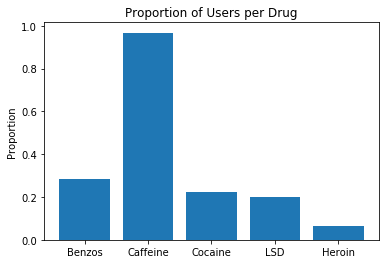

In [47]:
fig, ax = plt.subplots()
ax.bar(drugs,freq)
ax.set_title("Proportion of Users per Drug")
ax.set_ylabel("Proportion")

In [4]:
data = pd.DataFrame.to_numpy(data)
np.random.seed(1)
traindata, testdata = NNF.train_testSplit(data)

In [5]:
freq = [sum(traindata[:,i]) for i in range(13,18)]
freq

[400.0, 1367.0, 306.0, 279.0, 85.0]

In [8]:
trainDataset = NNF.drugData(traindata)
testDataset = NNF.drugData(testdata)
trainloader = torch.utils.data.DataLoader(trainDataset,
                                              batch_size=32,
                                              shuffle=True)

In [9]:
drugnet = NNF.Model(4)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(drugnet.parameters(), lr=0.03)
results = NNF.train(drugnet,criterion,optimizer,trainloader,200,pinterval=50)

epoch  0  loss:  29.921882152557373
epoch  50  loss:  15.064651161432266
epoch  100  loss:  14.52021498978138
epoch  150  loss:  14.305111974477768


In [12]:
yhatTest = NNF.getPredictions(drugnet, testDataset,normalize=False,roundtoint=True)
yhatTest1 = NNF.getPredictions(drugnet, testDataset,normalize=False,roundtoint=False)
yTest = testdata[:,13:]

In [29]:
hamming = sklm.hamming_loss(yTest,yhatTest)
subsetacc = sklm.accuracy_score(yTest,yhatTest)
aucA = sklm.roc_auc_score(yTest,yhatTest1,average=None)
auc = sklm.roc_auc_score(yTest,yhatTest1,average='weighted')

In [30]:
print(hamming)
print(subsetacc)
print(auc)
print(aucA)

0.1562632696390658
0.5201698513800425
0.6859095897902546
[0.7571649  0.59299781 0.75883383 0.89566497 0.7938287 ]


In [25]:
mcm = sklm.multilabel_confusion_matrix(yTest, yhatTest)
mcm

array([[[288,  48],
        [ 78,  57]],

       [[  0,  14],
        [  0, 457]],

       [[337,  23],
        [ 88,  23]],

       [[345,  25],
        [ 59,  42]],

       [[438,   0],
        [ 33,   0]]])

In [22]:
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]

In [27]:
recall = tp / (tp + fn)
recall

array([0.42222222, 1.        , 0.20720721, 0.41584158, 0.        ])

In [32]:
specificity = tn / (tn + fp)
specificity

array([0.85714286, 0.        , 0.93611111, 0.93243243, 1.        ])

In [33]:
accuracy = (tp+tn)/(tn+tp+fn+fp)
print(accuracy)

[0.73248408 0.97027601 0.76433121 0.82165605 0.92993631]
